<a href="https://colab.research.google.com/github/vaneesa-writes/micro_project/blob/main/nuclei_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# !kaggle competitions download -c data-science-bowl-2018

  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 58.4MB/s]
 82% 65.0M/79.1M [00:00<00:00, 91.3MB/s]
100% 79.1M/79.1M [00:00<00:00, 135MB/s] 
 97% 268M/276M [00:01<00:00, 152MB/s]
100% 276M/276M [00:01<00:00, 155MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 182MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 117MB/s]
 99% 9.00M/9.10M [00:00<00:00, 68.6MB/s]
100% 9.10M/9.10M [00:00<00:00, 55.8MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.67MB/s]


In [4]:
# import zipfile
# zf = "/content/stage1_test.zip"
# target_dir = "/content/stage1_test"
# zfile = zipfile.ZipFile(zf)
# zfile.extractall(target_dir)

In [5]:
!ls

drive				  stage1_test.zip
kaggle.json			  stage1_train
sample_data			  stage1_train_labels.csv.zip
stage1_sample_submission.csv.zip  stage1_train.zip
stage1_solution.csv.zip		  stage2_sample_submission_final.csv.zip
stage1_test			  stage2_test_final.zip


In [122]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
from skimage.measure import label, regionprops
import cv2

In [69]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
BATCH_SIZE = 32
seed = 4

In [8]:
TEST_PATH = '/content/stage1_test/'
TRAIN_PATH = '/content/stage1_train/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

Train Folder has **670** images with masks associated with every image 


 Test Folder has **65** images  

In [11]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print(path)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask
print(X_train.shape)

In [ ]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    #print(path + '/images/' + id_ + '.png')
    try:
      img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
      sizes_test.append([img.shape[0], img.shape[1]])
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_test[n] = img
    except:
      print('fail')

In [119]:
def draw_sub_plots(n,m,X,Y):
  f, axarr = plt.subplots(n,m,figsize=((10, 10)))
  ind=0
  for row in range(n):
    for col in range(m):
      if(col%2==0):
        img = X[row].reshape((128,128,3))
        axarr[row, 0].axis("off")
        axarr[row,0].imshow(img)
        title = "Train Image "+str(row+1)
        title_color = 'black'
        title = axarr[row, 0].set_title(title)
        plt.setp(title, color=title_color)
    else:
      img = Y[row]
      axarr[row, 1].axis("off")
      axarr[row,1].imshow(img)
      title = "Ground Truth Image "+str(row+1)
      title_color = 'black'
      title = axarr[row, 1].set_title(title)
      plt.setp(title, color=title_color)

In [51]:
X=[]
Y=[]
for ind in range(4):
  i = random.randint(0, len(train_ids))
  X.append(X_train[i])
  Y.append(np.squeeze(Y_train[i]))

These are some plots from the Train data

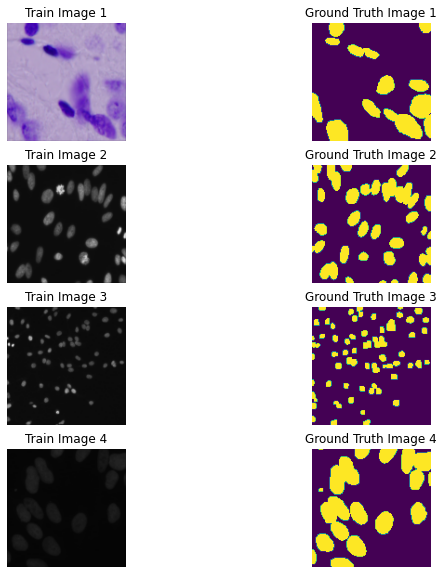

In [68]:
draw_sub_plots(4,2,X,Y)

Augmenting Train images

Train set has **603** images with masks

Validation set has **67** images with masks

In [70]:
from keras.preprocessing import image

image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


Agumneted Images and masks

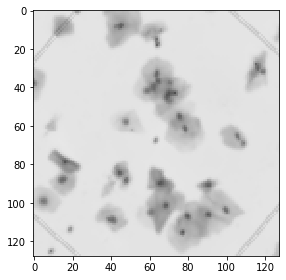

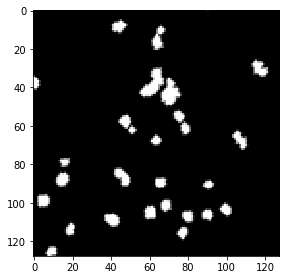

In [81]:
imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0]))
plt.show()

In [82]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [86]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

In [91]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

In [92]:
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=3, callbacks=[earlystopper, checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/3
250/250 [==============================] - ETA: 0s - loss: 0.2222 - mean_io_u: 0.4158
Epoch 00001: val_loss improved from inf to 0.08258, saving model to model-dsbowl2018-1.h5
250/250 [==============================] - 1386s 6s/step - loss: 0.2222 - mean_io_u: 0.4158 - val_loss: 0.0826 - val_mean_io_u: 0.4165
Epoch 2/3
250/250 [==============================] - ETA: 0s - loss: 0.1127 - mean_io_u: 0.4159
Epoch 00002: val_loss improved from 0.08258 to 0.07532, saving model to model-dsbowl2018-1.h5
250/250 [==============================] - 1374s 5s/step - loss: 0.1127 - mean_io_u: 0.4159 - val_loss: 0.0753 - val_mean_io_u: 0.4178
Epoch 3/3
250/250 [==============================] - ETA: 0s - loss: 0.1040 - mean_io_u: 0.4160
Epoch 00003: val_loss improved from 0.07532 to 0.07088, saving model to model-dsbowl2018-1.h5
250/250 [==============================] - 1384s 6s/step - loss: 0.1040 - mean_io_u: 0.4160 - val_loss: 0.0709 - val_mean_io_u: 0.4196


In [131]:
from keras.models import Model, load_model
model = load_model('model-dsbowl2018-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 3s 627ms/step


In [151]:
def draw_sub_plots_3(n,m,X,Y,Pred,name=True):
  f, axarr = plt.subplots(n,m,figsize=((15, 15)))
  ind=0
  for row in range(n):
    for col in range(m):
      if(col==0):
        img = X[row].reshape((128,128,3))
        axarr[row, 0].axis("off")
        axarr[row,0].imshow(img)
        title = "Train Image "+str(row+1)
        title_color = 'black'
        title = axarr[row, 0].set_title(title)
        plt.setp(title, color=title_color)
      
      elif(col==1):
        img = Y[row]
        axarr[row, 1].axis("off")
        axarr[row,1].imshow(img)
        if(name):
          title = "Ground Truth Image "+str(row+1)
        else:
          title = "Predicted Mask "+str(row+1)
        title_color = 'black'
        title = axarr[row, 1].set_title(title)
        plt.setp(title, color=title_color)
      else:
        img = Pred[row]
        axarr[row, 2].axis("off")
        axarr[row,2].imshow(img)
        title = "Predicted Image "+str(row+1)
        title_color = 'black'
        title = axarr[row, 2].set_title(title)
        plt.setp(title, color=title_color)



In [133]:
X=[]
Y=[]
Pred=[]
for ind in range(4):
  i = random.randint(0, 600)
  X.append(X_train[i])
  Y.append(np.squeeze(Y_train[i]))
  Pred.append(resize(np.squeeze(preds_train_t[i]), (128, 128), mode='constant', preserve_range=True))

Drawing some Images from Train Set

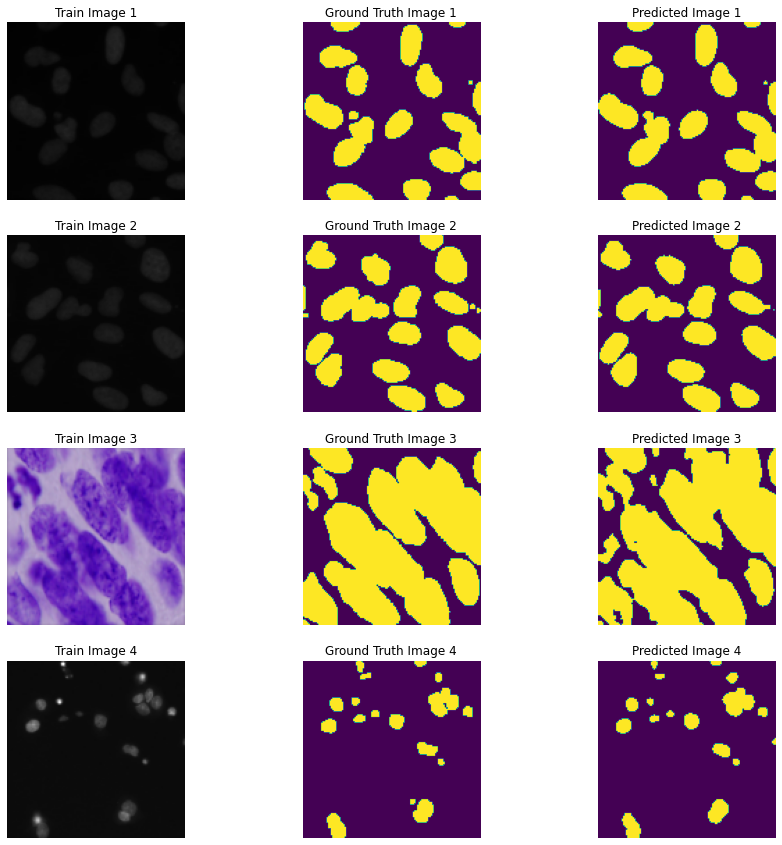

In [134]:
draw_sub_plots_3(4,3,X,Y,Pred)

In [146]:
X=[]
Y=[]
draw_over=[]
for ind in range(4):
  i = random.randint(0, 60)
  X.append(X_test[i])
  Y.append(resize(np.squeeze(preds_test_t[i]), (128, 128), mode='constant', preserve_range=True))
  image = np.squeeze(preds_test_t[i])
  img_1=X_test[i].copy()
  lbl_0 = label(image) 
  props = regionprops(lbl_0)
  for prop in props:
    cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 1)
  draw_over.append(img_1)

Drawing some Images from Test set

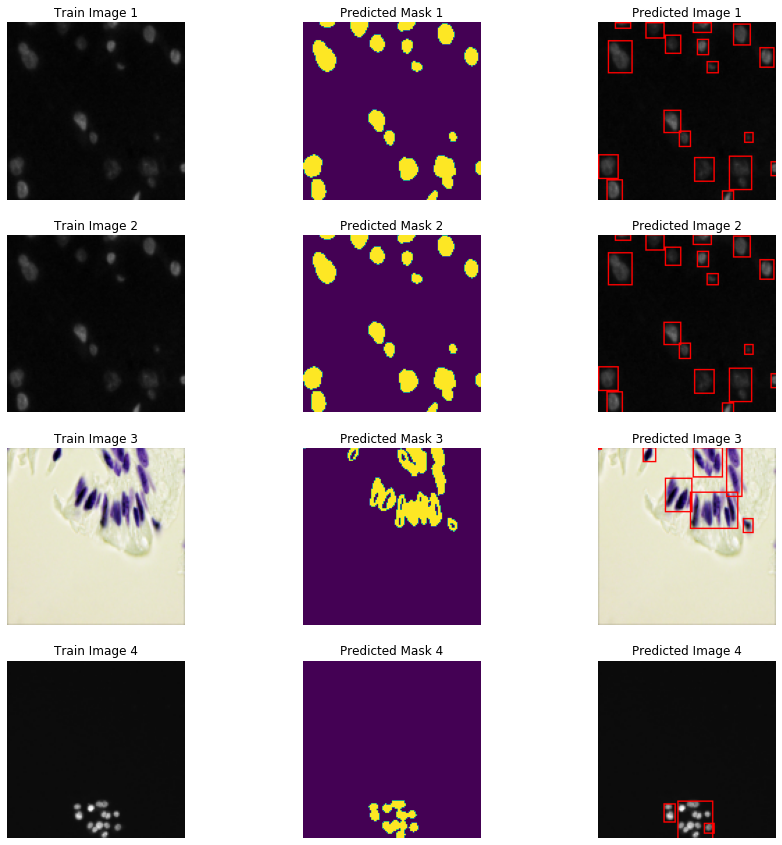

In [152]:
draw_sub_plots_3(4,3,X,Y,draw_over,False)

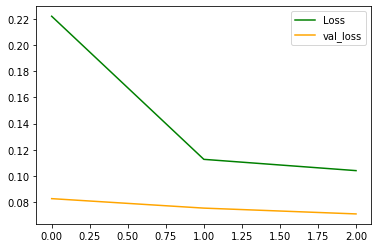

In [150]:
plt.style.use('_classic_test_patch')
plt.plot(results.history['loss'],c='green',label='Loss')
plt.plot(results.history['val_loss'],c='orange',label='val_loss')
plt.legend()
plt.show()